In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as D
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import math
import pylab as pl
from IPython import display
from IPython.core.display import HTML
from IPython.core.display import display as html_width
html_width(HTML("<style>.container { width:90% !important; }</style>"))

C:\Users\Igor\AppData\Local\Temp\ipykernel_9172\37510669.py:12: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display as html_width


In [2]:
suffix_name="4_trajectsX+tp_just_query" #used to save the network with different names among notebooks

### Generating a sample training distribution

These demonstrations are used in the first experiment of the __Conditional Neural Movement Primitives (RSS 2019) by Yunus Seker, Mert Imre, Justus Piater and Emre Ugur__

In __CNMP__, trajectories are defined as f(X) = Y where
  * __X__: includes time and task parameter information
  * __Y__: includes corresponding output (joint, endpoint, image, motor, etc.) for the given time and task parameters

This experiment does not involve external task parameters. 6 training and 4 validation trajectories are plotted below

training X  (6, 200, 2)
training Y  (6, 200, 1)
[[[0.         1.        ]
  [0.00502513 1.        ]
  [0.01005025 1.        ]
  ...
  [0.98994975 1.        ]
  [0.99497487 1.        ]
  [1.         1.        ]]

 [[0.         1.        ]
  [0.00502513 1.        ]
  [0.01005025 1.        ]
  ...
  [0.98994975 1.        ]
  [0.99497487 1.        ]
  [1.         1.        ]]

 [[0.         1.        ]
  [0.00502513 1.        ]
  [0.01005025 1.        ]
  ...
  [0.98994975 1.        ]
  [0.99497487 1.        ]
  [1.         1.        ]]

 [[0.         2.        ]
  [0.00502513 2.        ]
  [0.01005025 2.        ]
  ...
  [0.98994975 2.        ]
  [0.99497487 2.        ]
  [1.         2.        ]]

 [[0.         2.        ]
  [0.00502513 2.        ]
  [0.01005025 2.        ]
  ...
  [0.98994975 2.        ]
  [0.99497487 2.        ]
  [1.         2.        ]]

 [[0.         2.        ]
  [0.00502513 2.        ]
  [0.01005025 2.        ]
  ...
  [0.98994975 2.        ]
  [0.99497487 2.      

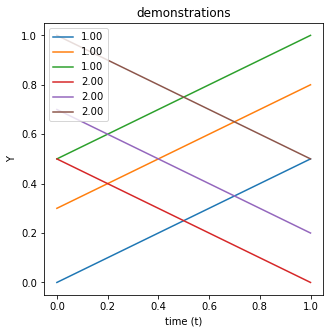

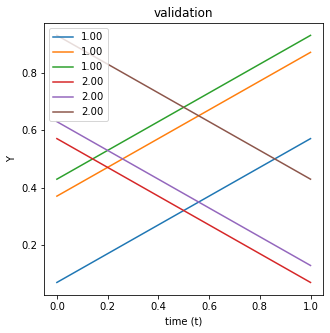

In [3]:
### you can use https://www.desmos.com/calculator to find the parameters of the desired curves below
def distribution_generator(x, param, noise=0):
    f = (exp(-x**2/(2.*param[0]**2))/(sqrt(2*math.pi)*param[0]))+param[1]
    return f+(noise*np.random.rand()/100.)

def line_generator(x, m,q, noise=0):
    return m*x+q +(noise*np.random.rand()/100.)

def parabolic_curve(x, a, b, c, noise=0):
    return a*x**2+b*x+c +(noise*np.random.rand()/100.)

def sin_generator(x, a, f, h=0, v=0, noise=0):
    return a*np.sin(f*(x-h))+v +(noise*np.random.rand()/100.)

def generate_demonstrations(time_steps, title = None):
    noise=0
    if title=="Validation Demonstrations":
        import random
        noise=random.uniform(0.0, 0.3)
    x = np.linspace(0,1,time_steps) #array of 200 elems between two numbers
    times = np.zeros((6,time_steps,2)) #array of (num_demonstrations) elems with 200 elems (time_steps) with 2 elem (dimensions: x and task-parameters)
    times[:, :, 0] = x #to all demonstration, to all 200 times, only in first position put the x 
    times[0, :, 1] = 1 #to first demonstration, to all 200 times in second dimension put the task-parameters
    times[1, :, 1] = 1
    times[2, :, 1] = 1
    times[3, :, 1] = 2
    times[4, :, 1] = 2
    times[5, :, 1] = 2
    values = np.zeros((6,time_steps,1)) #array of (num_demonstrations) elems with 200 elems (time_steps)
    for i in range(time_steps): #for all times
        values[0,i] = line_generator(x=x[i],m=0.5, q=0.0+noise)
        values[1,i] = line_generator(x=x[i],m=0.5, q=0.3+noise)
        values[2,i] = line_generator(x=x[i],m=0.5, q=0.5-noise)
        values[3,i] = line_generator(x=x[i],m=-0.5, q=0.5+noise)
        values[4,i] = line_generator(x=x[i],m=-0.5, q=0.7-noise)
        values[5,i] = line_generator(x=x[i],m=-0.5, q=1.0-noise)
    return times, values

time_steps=200
X, Y = generate_demonstrations(time_steps, title='Training Demonstrations')
v_X, v_Y = generate_demonstrations(time_steps, title='Validation Demonstrations')

print('training X ', X.shape)
print('training Y ',Y.shape)
print(X)
print('validation X ', v_X.shape)
print('validation Y ',v_Y.shape)
#plot demonstrations
fig = plt.figure(figsize=(5,5))
for d in range(X.shape[0]):
    plt.plot(X[d, :,0], Y[d],label="%.2f"%(X[d][0][1]) )
plt.title("demonstrations")
plt.ylabel('Y')
plt.xlabel('time (t)')
plt.legend()
plt.show()
#plot validation 
fig = plt.figure(figsize=(5,5))
for d in range(X.shape[0]):
    plt.plot(v_X[d, :,0], v_Y[d],label="%.2f"%(X[d][0][1]) )
plt.title("validation")
plt.ylabel('Y')
plt.xlabel('time (t)')
plt.legend()
plt.show()
#save
np.save('training_X',X)
np.save('training_Y',Y)
np.save('validation_X',v_X)
np.save('validation_Y',v_Y)

### Initialization

Input Requirements:

  * __obs_max__: Hyperparameter that decides to the maximum number of observations CNMP uses. In this experiment, it is set to 5

  * __d_N__: Number of demonstrations

  * __d_x__: X vector feature dim (*NOTE THAT*: task parameters are assumed to be inside of the X vector, concatenated to time value. This experiment does not use external parameters so d_x = 1)

  * __d_y__: Y vector feature dim (In this experiment the output of trajectories are 1D single values so d_y = 1)

  * __time_len__: length of the demonstrations, if all demonstrations does not have same length, use array and edit methods using time_len, or preprocess your data to interpolate into same time length (check numpy.interp)

  * __X__: shape=(d_N,time_len,d_x) --- time (and external parameter) values for each timestep for ith demonstration. d_x = 1+d_external_parameters

  * __Y__: shape=(d_N,time_len,d_y) --- corresponding values of f(X) for ith demonstration

In [4]:
X, Y = (np.load('training_X.npy'), np.load('training_Y.npy'))
v_X, v_Y = (np.load('validation_X.npy'), np.load('validation_Y.npy'))
obs_max = 5 
d_N = X.shape[0] 
d_x , d_y = (X.shape[-1] , Y.shape[-1])
time_len = X.shape[1] 

print('d_N = %d'%d_N)
print('obs_max = %d'%obs_max)
print('X = %s'%(X.shape,))
print('Y = %s'%(Y.shape,))
print('d_x = %d'%d_x)
print('d_y = %d'%d_y)
print('time_len = %d'%time_len)

d_N = 6
obs_max = 5
X = (6, 200, 2)
Y = (6, 200, 1)
d_x = 2
d_y = 1
time_len = 200


# Conditional Neural Movement Primitives

### get_train_sample():

* Selects a random observation number __n__

* Selects a random demonstration id __d__

* Permutes demonstration __d__, so the first __n__ data can be sampled as __observations__. Selects __(n+1)th__ data to be the __target point__ that __CNMP__ will try to predict

* Returns:
  * __observations__: A batch that includes sampled observations
  * __target_X__: A batch that includes all target timesteps
  * __target_Y__: A batch that includes corresponding output for sampled __target_X__ timestep

__NOTICE__: In training, the size of the __target_X__ batch is set to __1__. But in test time, __any size__ of multiple timesteps can be queried as a batch. This allows __whole trajectory prediction at once__.

In [5]:
def get_train_sample():
    n = np.random.randint(0,obs_max)+1
    d = np.random.randint(0, d_N)
    
    observations = np.zeros((n,d_x+d_y)) 
    target_X = np.zeros((1,d_x))
    target_Y = np.zeros((1,d_y))
    
    perm = np.random.permutation(time_len)
    observations[:n,:d_x] = X[d,perm[:n]]
    observations[:n,d_x:d_x+d_y] = Y[d,perm[:n]]
    target_X[0] = X[d,perm[n]]
    target_Y[0] = Y[d,perm[n]]
    return torch.from_numpy(np.delete(observations, 1, axis=1)), torch.from_numpy(target_X), torch.from_numpy(target_Y) #edit here to pass only the x observation without tp

observations=1
tensor([[0.2965, 0.6482]], dtype=torch.float64)
query x:
tensor([[0.0653, 1.0000]], dtype=torch.float64)
true y:
tensor([[0.5327]], dtype=torch.float64)


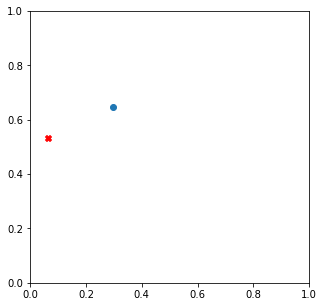

In [6]:
# example training sample
o,tx,ty = get_train_sample()
print("observations="+str(len(o)))
print(o)
print("query x:")
print(tx)
print("true y:")
print(ty)
fig = plt.figure(figsize=(5,5))
for j in range(len(o)):
    plt.scatter(o[j][0].item(),o[j][-1].item())
plt.scatter(tx[0][0],ty,marker="X",color='red')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show() 

### predict_model(observations, target_X, plot):
Predicts outputs according to the given __observations__ and __target_X batch__.

* __observations__: Batch of observations. Dimensions = (obs_n, d_x+d_y) where __obs_n__ is the number of observations will ve used for this prediction
* __target_X__: Batch of time points to be predicted. Dimension = (target_n, d_x) where __target_n__ is the number of points to predict

*For whole trajectory prediction give all X points through time length as a batch (for ex. the first demonstration = X[0])*

* __prediction__: Predicted __means__ and __standart deviations__ for each time point in the X. Later splitted into __predicted_Y__ and __predicted_std__
* __plot__: if __True__, plots demonstrations and predicted distribution

In [7]:
def predict_model(observations, target_X, plot = True):
    predicted_Y = np.zeros((time_len,d_y))
    predicted_std = np.zeros((time_len,d_y))
    with torch.no_grad():
        prediction = model(torch.from_numpy(observations),torch.from_numpy(target_X)).numpy()
    predicted_Y = prediction[:,:d_y]
    predicted_std = np.log(1+np.exp(prediction[:,d_y:]))
    if plot: # We highly recommend that you customize your own plot function, but you can use this function as default
        for i in range(d_y): #for every feature in Y vector we are plotting training data and its prediction
            fig = plt.figure(figsize=(5,5))
            for j in range(d_N):
                plt.plot(X[j,:,0],Y[j,:,i]) # plot training data assuming X[j,:,0] is time
            #plt.plot(X[j,:,0],predicted_Y[:,i],marker="o",color='red')
            plt.errorbar(X[j,:,0],predicted_Y[:,i],yerr=predicted_std[:,i],color = 'black',alpha=0.4)
            plt.scatter(observations[:,0],observations[:,-1],marker="X",color='black') #edit here to pass only x without tp
            plt.show()  
    return predicted_Y, predicted_std

### custom_loss(output, target):

Calculates __log probability__ of the true value of the target point according to the __multivariate Gaussian__ constructed by __predicted means__ and __stds__

Returns minus of that value

In [8]:
def log_prob_loss(output, target):
    mean, sigma = output.chunk(2, dim = -1)
    sigma = F.softplus(sigma)
    dist = D.Independent(D.Normal(loc=mean, scale=sigma), 1)
    return -torch.mean(dist.log_prob(target))

### CNMP Module

* __encoder__: Observation encoder module that takes a batch of __observations__ and converts each of them to their latent space representations

* __decoder__: Decoder module that takes the batch of __r_mean__ and __target_t__ tuples and produces mean and std values for each dimension of the output

*NOTICE: __Observation encoding__ is a __parallelized operation__ which __none__ of the inputs are dependent on each other and __none__ of the outputs are affected by the values of others in the batch*

In [9]:
class CNMP(nn.Module):
    
    def __init__(self):
        super(CNMP, self).__init__()
        
        # Encoder takes observations which are (X,Y) tuples and produces latent representations for each of them
        self.encoder = nn.Sequential(
        nn.Linear(d_x-1+d_y,128),nn.ReLU(), #edit here to pass only x without tp
        nn.Linear(128,128),nn.ReLU(),
        nn.Linear(128,128)
        )
        
        #Decoder takes the (r_mean, target_t) tuple and produces mean and std values for each dimension of the output
        self.decoder = nn.Sequential(
        nn.Linear(128+d_x,128),nn.ReLU(), 
        nn.Linear(128,128),nn.ReLU(),
        nn.Linear(128,2*d_y)
        )
        
    def forward(self,observations,target_t):
        r = self.encoder(observations) # Generating observations
        r_mean = torch.mean(r,dim=0) # Taking mean and generating the general representation
        r_mean = r_mean.repeat(target_t.shape[0],1) # Duplicating general representation for every target_t
        concat = torch.cat((r_mean,target_t),dim=-1) # Concatenating each target_t with general representation
        output = self.decoder(concat) # Producing mean and std values for each target_t
        return output

### Initializing the model

In [9]:
model = CNMP().double()
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### Training the CNMP

In [10]:
np.delete(v_X[1,2], 1, axis=0)

array([0.01005025])

<Figure size 432x288 with 0 Axes>

990000


<Figure size 432x288 with 0 Axes>

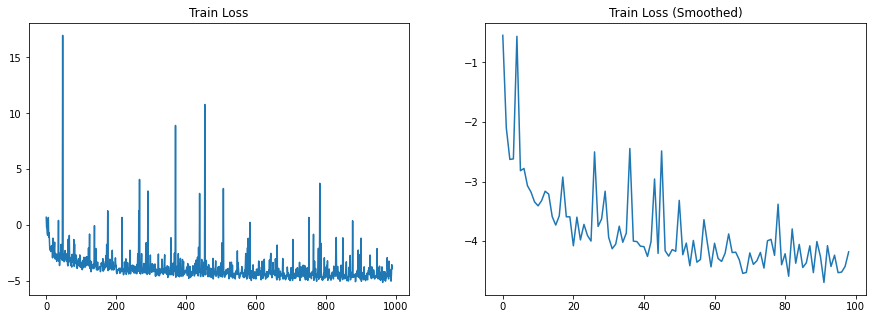

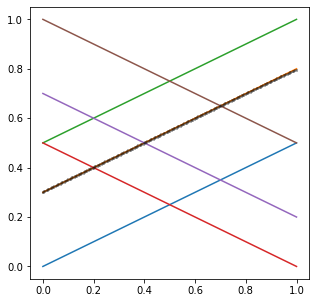

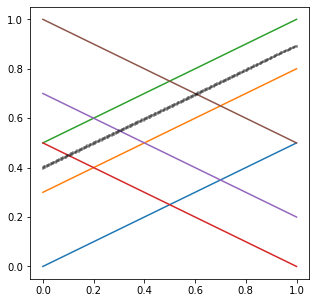

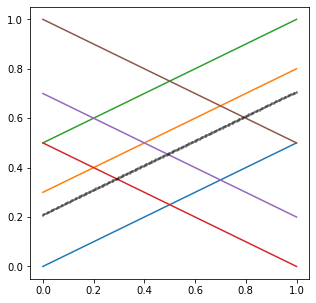

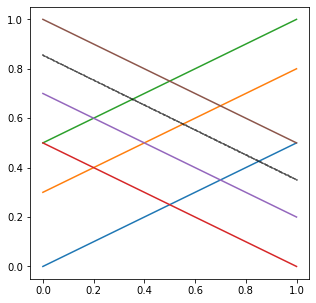

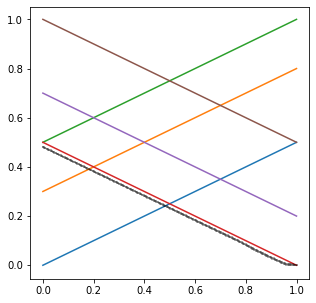

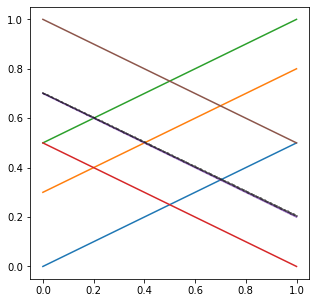

Finished Training


In [11]:
smooth_losses = [0]
losses = []
loss_checkpoint = 1000
plot_checkpoint = 10000
validation_checkpoint = 100
validation_error = 9999999

for step in range(1000000):  # loop over the dataset multiple times
    observations, target_t, target_output = get_train_sample()
    
    optimizer.zero_grad()

    output = model(observations, target_t)
    loss = log_prob_loss(output, target_output)
    loss.backward()
    optimizer.step()
    
    if step % loss_checkpoint == 0:
        losses.append(loss.data)
        smooth_losses[-1] += loss.data/(plot_checkpoint/loss_checkpoint)
    
    if step % validation_checkpoint == 0:
        current_error = 0
        for i in range(v_X.shape[0]):
            predicted_Y,predicted_std = predict_model(np.array([np.concatenate((np.delete(v_X[i,0], 1, axis=0),v_Y[i,0]))]), v_X[i], plot= False) #edit here to pass only with first element and not tp
            current_error += np.mean((predicted_Y - v_Y[i,:])**2) / v_X.shape[0]
        if current_error < validation_error:
            validation_error = current_error
            torch.save(model.state_dict(), 'cnmp_best_validation'+suffix_name+'.h5')
            print(' New validation best. Error is ', current_error)
        
    if step % plot_checkpoint == 0:
        #clearing output cell
        display.clear_output(wait=True)
        display.display(pl.gcf())
        
        print(step)
        #plotting training examples and smoothed losses
        
        plt.figure(figsize=(15,5))
        plt.subplot(121)
        plt.title('Train Loss')
        plt.plot(range(len(losses)),losses)
        plt.subplot(122)
        plt.title('Train Loss (Smoothed)')
        plt.plot(range(len(smooth_losses)),smooth_losses)
        plt.show()
        
        #plotting validation cases
        for i in range(v_X.shape[0]):
            predict_model(np.array([np.concatenate((np.delete(v_X[i,0], 1, axis=0),v_Y[i,0]))]), v_X[i]) #edit here to pass v_X only with first element and not tp
        
        if step!=0:
            smooth_losses.append(0)
print('Finished Training')
torch.save(model.state_dict(), 'cnmp_best_validation'+suffix_name+'LAST.h5')

### Loading Best Model

In [27]:
model = CNMP().double()
model.load_state_dict(torch.load('cnmp_best_validation'+suffix_name+'.h5'))
model.eval()

CNMP(
  (encoder): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=130, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=2, bias=True)
  )
)

### Testing the Model

In [28]:
time_queries1=v_X[0]
time_queries2=v_X[4]

#### Normal prediction

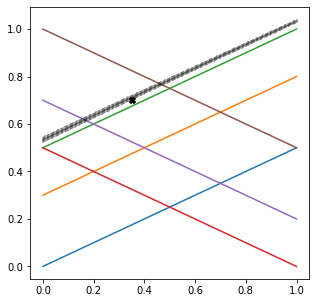

In [29]:
predicted_Y,predicted_std = predict_model(observations=np.array([np.concatenate(([0.35],[0.7]))]), target_X=time_queries1)

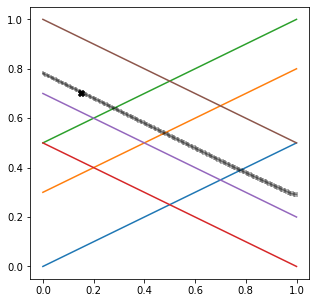

In [30]:
predicted_Y,predicted_std = predict_model(observations=np.array([np.concatenate(([0.15],[0.7]))]), target_X=time_queries2)

#### Uncertain Prediction not existing in this case

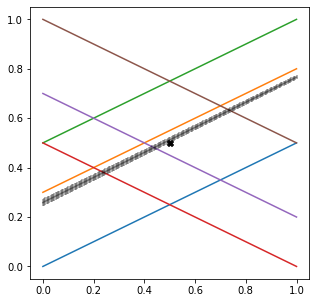

In [31]:
predicted_Y,predicted_std = predict_model(observations=np.array([np.concatenate(([0.50],[0.5]))]), target_X=time_queries1)

#### More observations

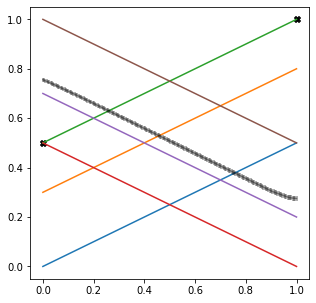

In [32]:
predicted_Y,predicted_std = predict_model(observations=np.array([np.concatenate(([0.00],[0.50])),np.concatenate(([1.00],[1.0])),]), target_X=time_queries2)

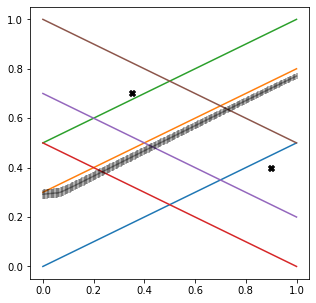

In [33]:
predicted_Y,predicted_std = predict_model(observations=np.array([np.concatenate(([0.35],[0.7])),np.concatenate(([0.9],[0.4]))]), target_X=time_queries1)

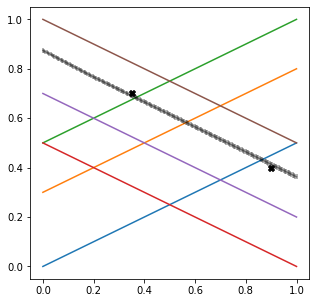

In [34]:
predicted_Y,predicted_std = predict_model(observations=np.array([np.concatenate(([0.35],[0.7])),np.concatenate(([0.9],[0.4]))]), target_X=time_queries2)

## OUT OF BOUNDS TEST

In [35]:
def predict_model_free(observations, target_Xs, plot = True):
    predicted_Y = np.zeros((target_Xs.shape[0],d_y)) #number of Xs of dimension of Y elems
    predicted_std = np.zeros((target_Xs.shape[0],d_y))
    with torch.no_grad():
        prediction = model(torch.from_numpy(observations),torch.from_numpy(target_Xs)).numpy() 
    predicted_Y = prediction[:,:d_y]
    predicted_std = np.log(1+np.exp(prediction[:,d_y:]))
    if plot: 
        for i in range(d_y): #for every dimension in Y vector we are plotting training data and prediction
            fig = plt.figure(figsize=(8,8))
            for dem in range(d_N): #for all demonstration
                plt.plot(X[dem,:,0],Y[dem,:,i]) # plot training data
            plt.scatter(observations[:,0],observations[:,1],marker="X",color='black') #plot observations
            #plot preditions
            #plt.plot(target_Xs,predicted_Y[:,i],marker="X",color='red',markersize=2)
            plt.errorbar(target_Xs[:,0],predicted_Y[:,i],yerr=predicted_std[:,i],color = 'black',alpha=0.4)
            plt.show()  
    return predicted_Y, predicted_std

In [36]:
lol=np.linspace(-1,2,200) # 200 elems from to 
pred_range = np.zeros((200,2))
pred_range[:, 0]= lol #now each of the 200 elems has an elem that has the range
pred_range[:,1] = 1 # to all 200 times in second dimension put the first goal
pred_range2=pred_range.copy()
pred_range2[:,1] = 2 # to all 200 times in second dimension put the first goal
#pred_range
#pred_range=np.delete(pred_range, 1, axis=1)
print(pred_range.shape)
print(X[0].shape)

(200, 2)
(200, 2)


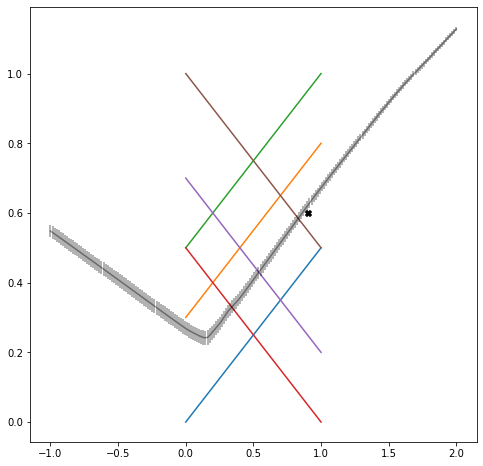

In [37]:
#RUN THE MODEL PREDICTIONS UNBOUNDED
predicted_Y,predicted_std = predict_model_free(np.array([np.concatenate(([0.9],[0.6]))]), pred_range)

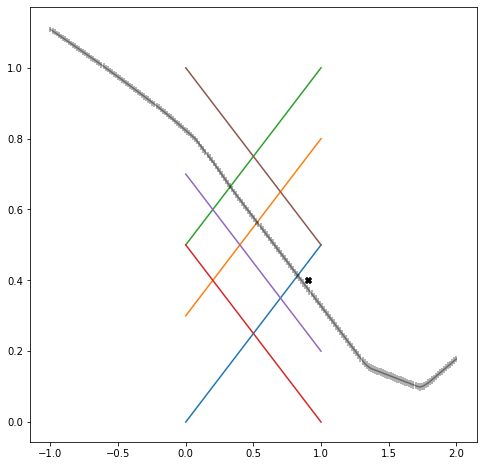

In [38]:
predicted_Y,predicted_std = predict_model_free(np.array([np.concatenate(([0.9],[0.4]))]), pred_range2)

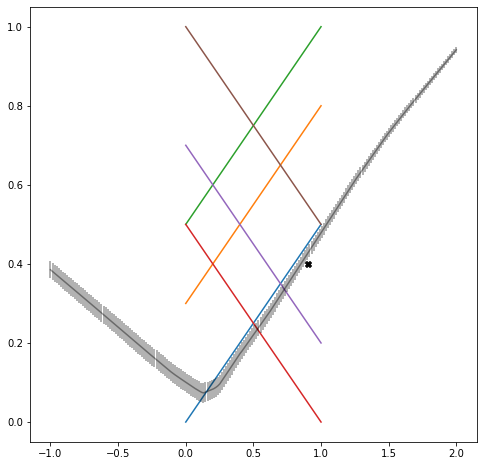

In [39]:
predicted_Y,predicted_std = predict_model_free(np.array([np.concatenate(([0.9],[0.4]))]), pred_range)

## 3D Plot

In [40]:
num_tp_samples=34#17
min_tp=2
max_tp=1
all_tp = np.zeros((num_tp_samples,2))
all_tp[:,0] = np.linspace(0,num_tp_samples-1,num_tp_samples) #indexes in first place
all_tp[:,1] = np.linspace(min_tp,max_tp,num_tp_samples) #tps in second place
tp_value_array = all_tp[:,1] #array of task parameters only
print(all_tp)
# index   task parameter

[[ 0.          2.        ]
 [ 1.          1.96969697]
 [ 2.          1.93939394]
 [ 3.          1.90909091]
 [ 4.          1.87878788]
 [ 5.          1.84848485]
 [ 6.          1.81818182]
 [ 7.          1.78787879]
 [ 8.          1.75757576]
 [ 9.          1.72727273]
 [10.          1.6969697 ]
 [11.          1.66666667]
 [12.          1.63636364]
 [13.          1.60606061]
 [14.          1.57575758]
 [15.          1.54545455]
 [16.          1.51515152]
 [17.          1.48484848]
 [18.          1.45454545]
 [19.          1.42424242]
 [20.          1.39393939]
 [21.          1.36363636]
 [22.          1.33333333]
 [23.          1.3030303 ]
 [24.          1.27272727]
 [25.          1.24242424]
 [26.          1.21212121]
 [27.          1.18181818]
 [28.          1.15151515]
 [29.          1.12121212]
 [30.          1.09090909]
 [31.          1.06060606]
 [32.          1.03030303]
 [33.          1.        ]]


In [41]:
num_time_samples=200
time_queries = np.zeros((num_time_samples,2)) # 2 dimensions (time and tp)
time_queries[:,0] = np.linspace(0,1,num_time_samples) #times in first place
time_queries[:,1] = -1 #task parameter will be filled later with each one desired
print(time_queries)
#time        task parameter

[[ 0.         -1.        ]
 [ 0.00502513 -1.        ]
 [ 0.01005025 -1.        ]
 [ 0.01507538 -1.        ]
 [ 0.0201005  -1.        ]
 [ 0.02512563 -1.        ]
 [ 0.03015075 -1.        ]
 [ 0.03517588 -1.        ]
 [ 0.04020101 -1.        ]
 [ 0.04522613 -1.        ]
 [ 0.05025126 -1.        ]
 [ 0.05527638 -1.        ]
 [ 0.06030151 -1.        ]
 [ 0.06532663 -1.        ]
 [ 0.07035176 -1.        ]
 [ 0.07537688 -1.        ]
 [ 0.08040201 -1.        ]
 [ 0.08542714 -1.        ]
 [ 0.09045226 -1.        ]
 [ 0.09547739 -1.        ]
 [ 0.10050251 -1.        ]
 [ 0.10552764 -1.        ]
 [ 0.11055276 -1.        ]
 [ 0.11557789 -1.        ]
 [ 0.12060302 -1.        ]
 [ 0.12562814 -1.        ]
 [ 0.13065327 -1.        ]
 [ 0.13567839 -1.        ]
 [ 0.14070352 -1.        ]
 [ 0.14572864 -1.        ]
 [ 0.15075377 -1.        ]
 [ 0.15577889 -1.        ]
 [ 0.16080402 -1.        ]
 [ 0.16582915 -1.        ]
 [ 0.17085427 -1.        ]
 [ 0.1758794  -1.        ]
 [ 0.18090452 -1.        ]
 

In [42]:
graph = np.zeros((num_tp_samples,num_time_samples,3)) #for every task parameter, for every time queries contains data
graph[:,:,0]=time_queries[:,0] #first position times
repeated_tp_value_array=np.tile(tp_value_array, (num_time_samples,1)) # many times the tp array
graph[:,:,1]=repeated_tp_value_array.T #second position task parameter
print(graph.shape)
print(graph)
graph_std=graph.copy()

(34, 200, 3)
[[[0.         2.         0.        ]
  [0.00502513 2.         0.        ]
  [0.01005025 2.         0.        ]
  ...
  [0.98994975 2.         0.        ]
  [0.99497487 2.         0.        ]
  [1.         2.         0.        ]]

 [[0.         1.96969697 0.        ]
  [0.00502513 1.96969697 0.        ]
  [0.01005025 1.96969697 0.        ]
  ...
  [0.98994975 1.96969697 0.        ]
  [0.99497487 1.96969697 0.        ]
  [1.         1.96969697 0.        ]]

 [[0.         1.93939394 0.        ]
  [0.00502513 1.93939394 0.        ]
  [0.01005025 1.93939394 0.        ]
  ...
  [0.98994975 1.93939394 0.        ]
  [0.99497487 1.93939394 0.        ]
  [1.         1.93939394 0.        ]]

 ...

 [[0.         1.06060606 0.        ]
  [0.00502513 1.06060606 0.        ]
  [0.01005025 1.06060606 0.        ]
  ...
  [0.98994975 1.06060606 0.        ]
  [0.99497487 1.06060606 0.        ]
  [1.         1.06060606 0.        ]]

 [[0.         1.03030303 0.        ]
  [0.00502513 1.03030303

2.0


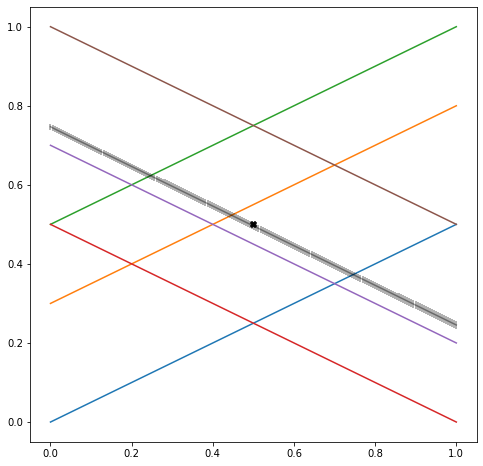

1.9696969696969697


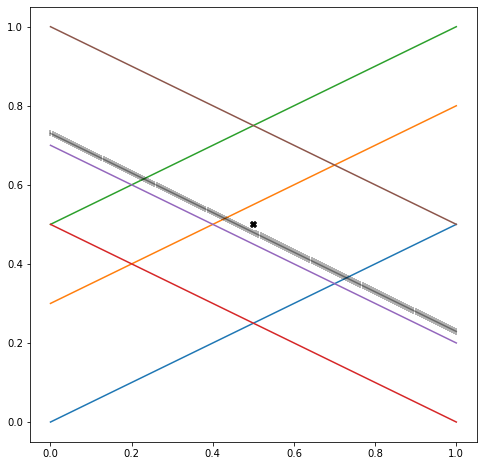

1.9393939393939394


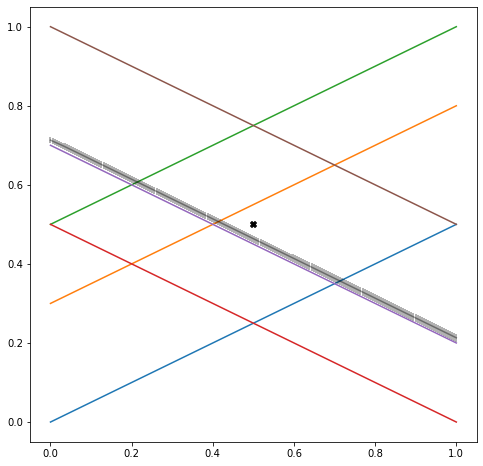

1.9090909090909092


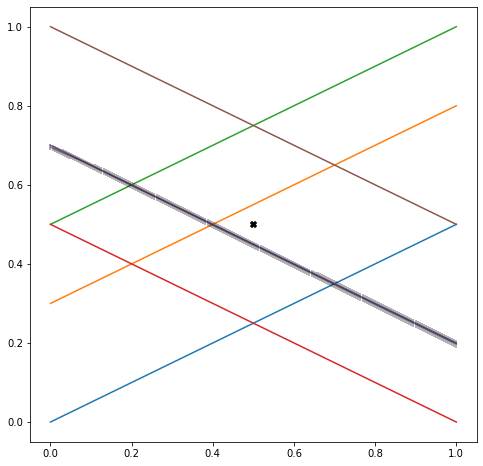

1.878787878787879


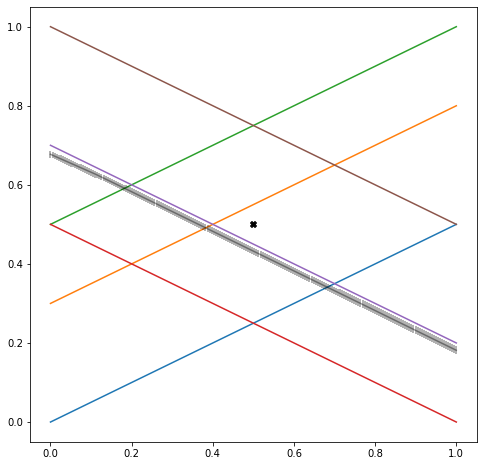

1.8484848484848484


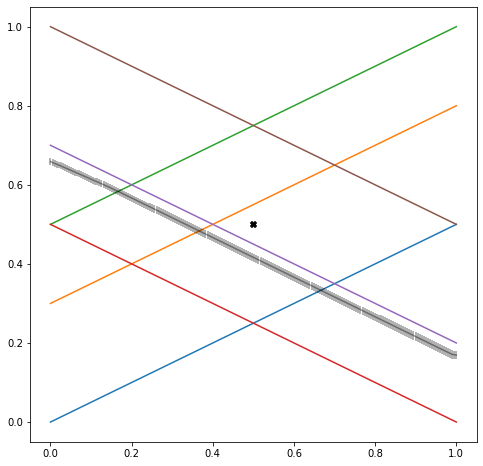

1.8181818181818181


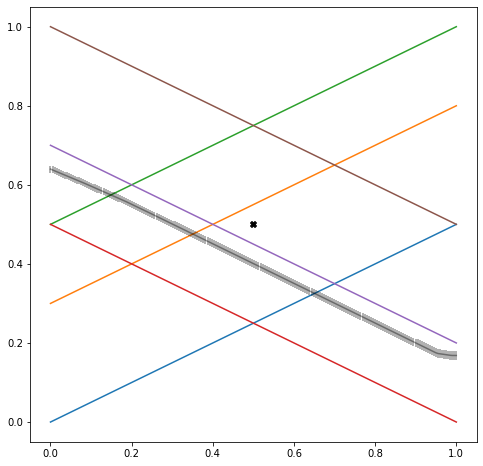

1.7878787878787878


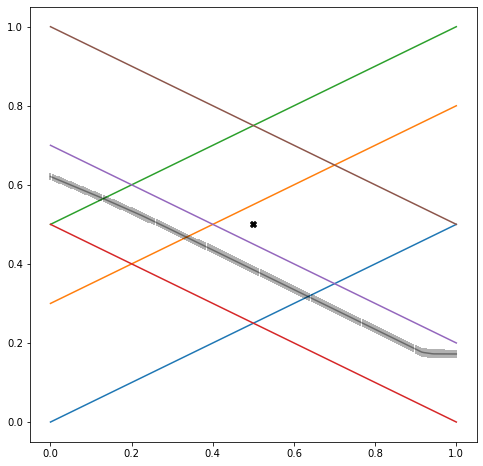

1.7575757575757576


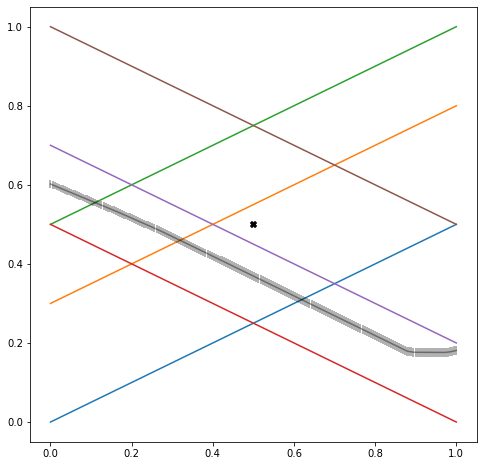

1.7272727272727273


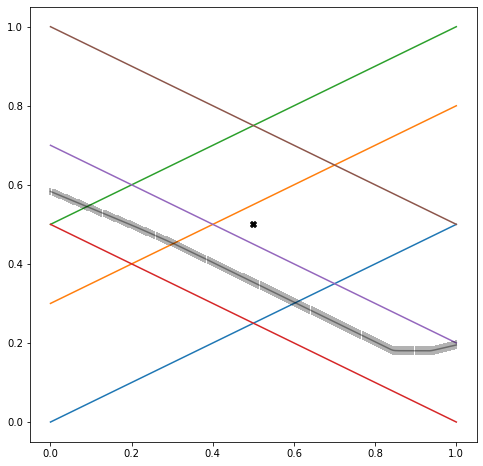

1.696969696969697


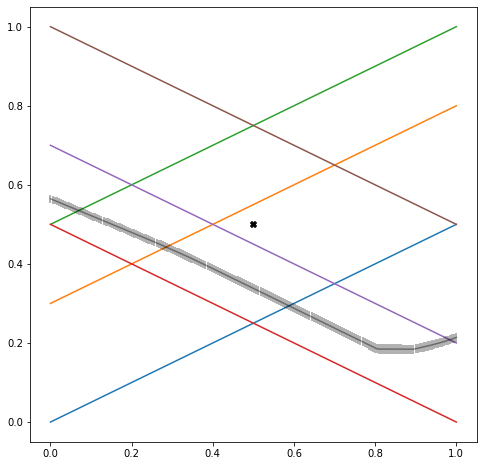

1.6666666666666665


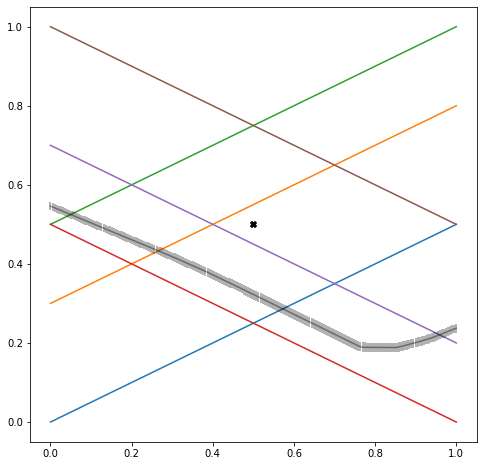

1.6363636363636362


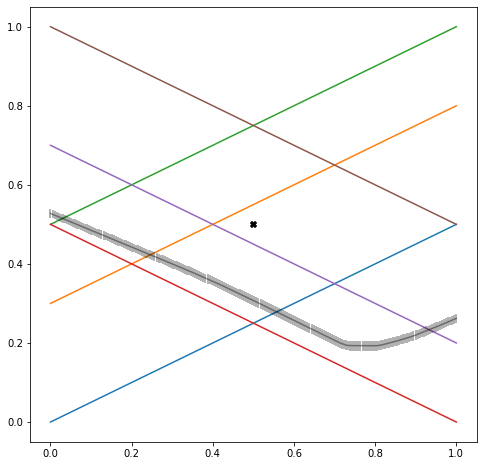

1.606060606060606


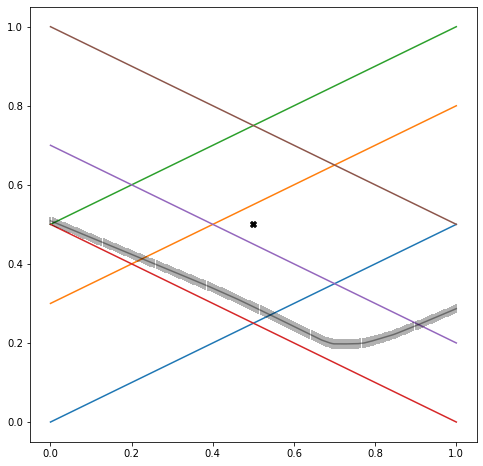

1.5757575757575757


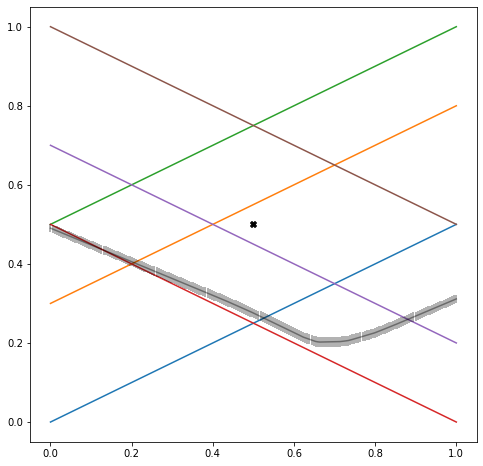

1.5454545454545454


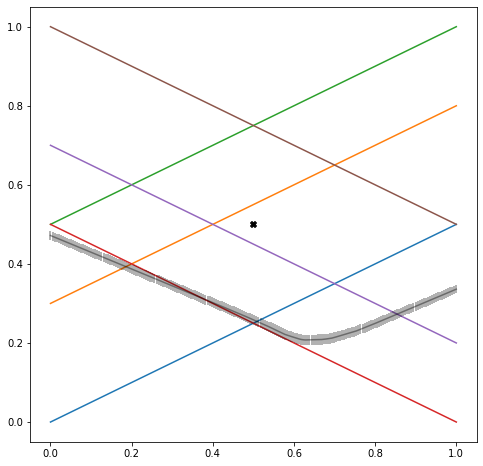

1.5151515151515151


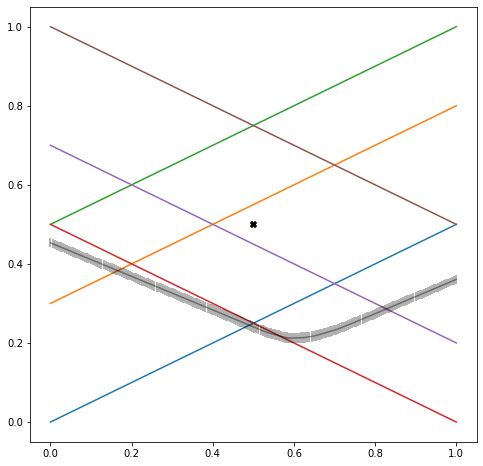

1.4848484848484849


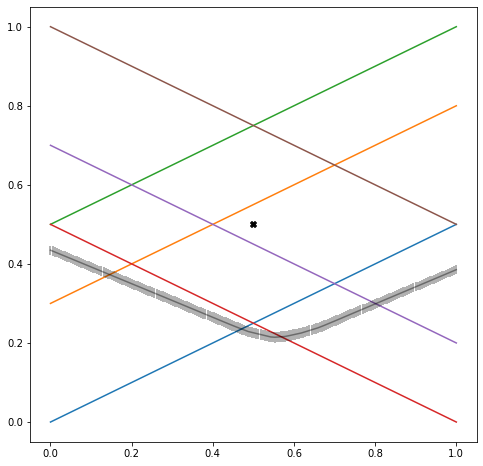

1.4545454545454546


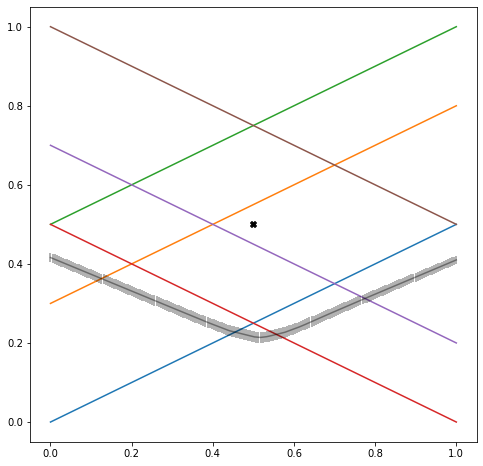

1.4242424242424243


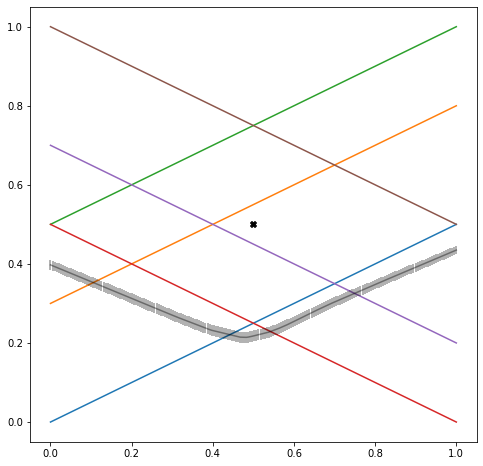

1.393939393939394


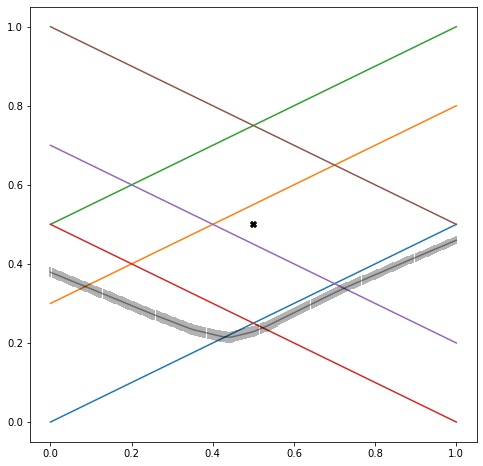

1.3636363636363638


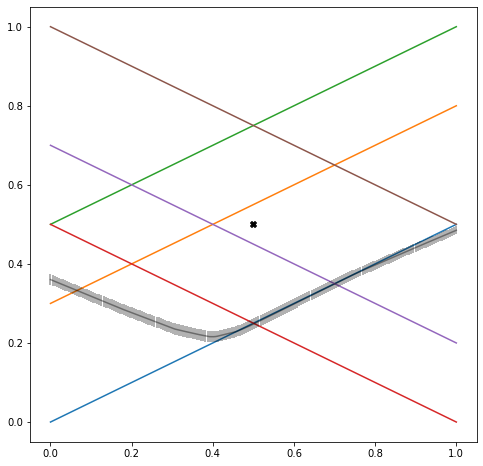

1.3333333333333333


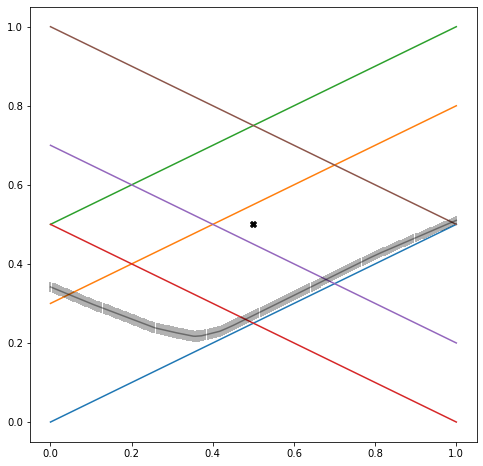

1.303030303030303


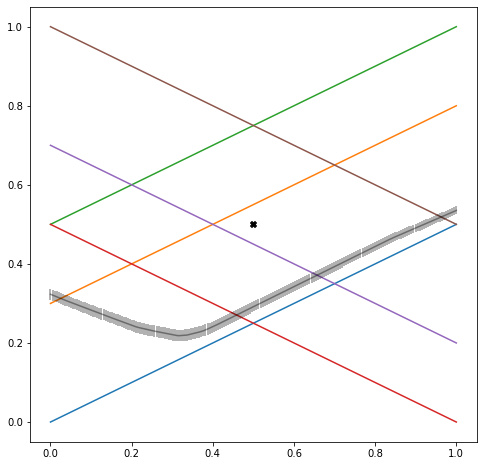

1.2727272727272727


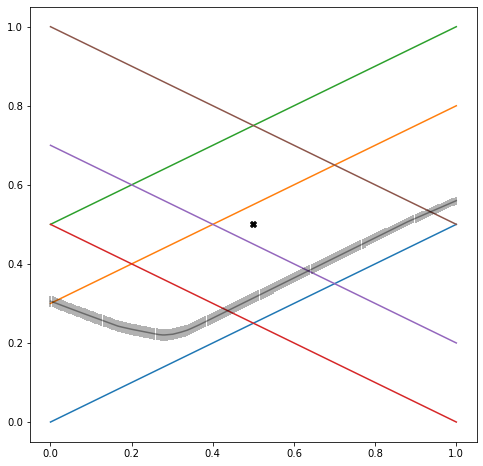

1.2424242424242424


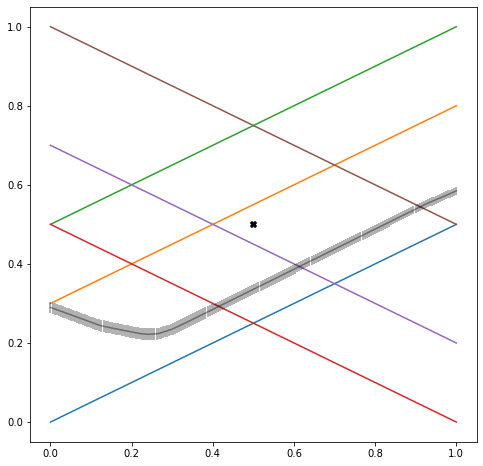

1.2121212121212122


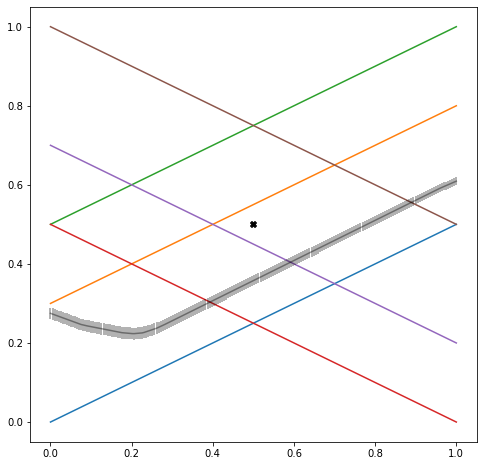

1.1818181818181817


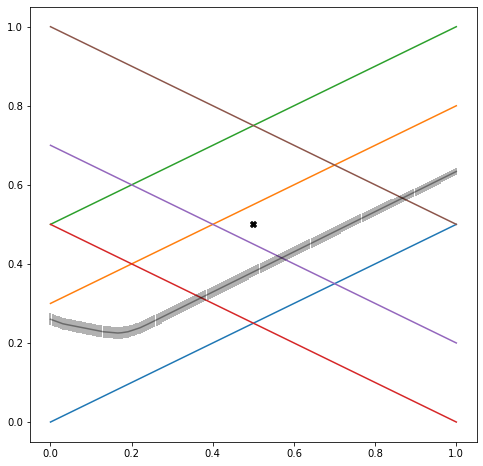

1.1515151515151514


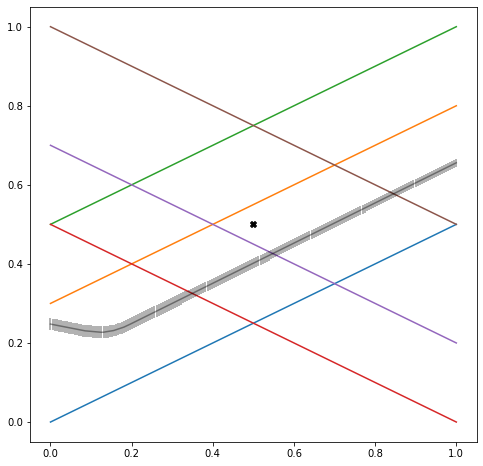

1.121212121212121


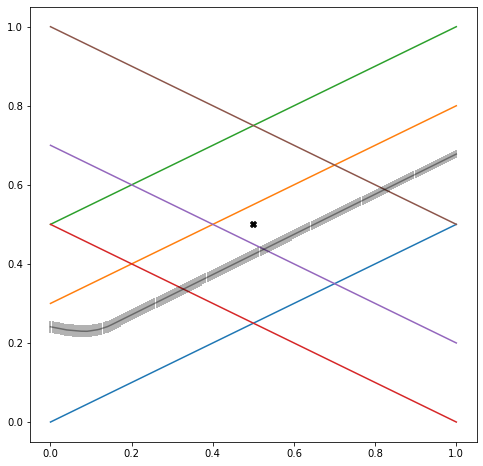

1.0909090909090908


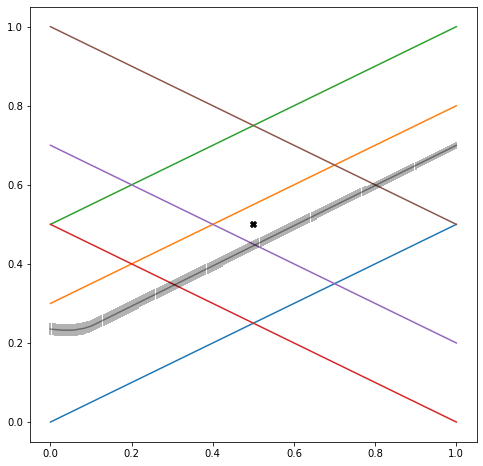

1.0606060606060606


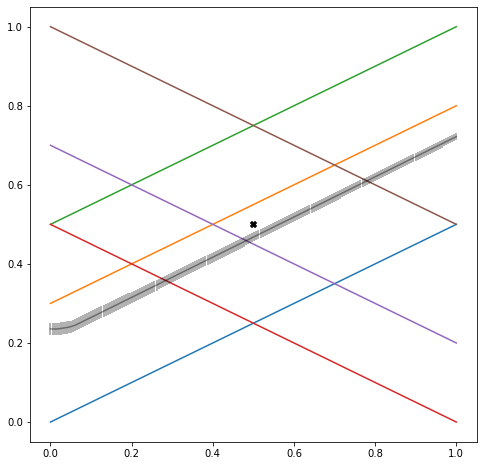

1.0303030303030303


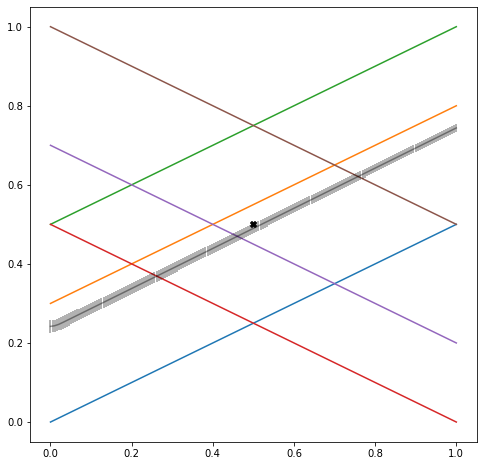

1.0


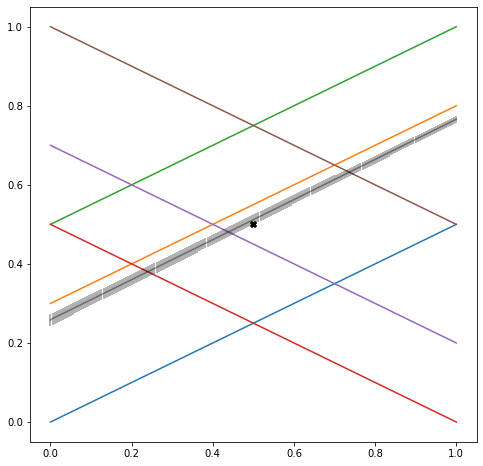

In [43]:
for curr_tp in all_tp:
    curr_tp_index,curr_tp_value = curr_tp[0],curr_tp[1]
    print(curr_tp_value)
    time_queries[:,1] = curr_tp_value
    predicted_Ys,predicted_std=predict_model_free(np.array([np.concatenate(([0.5],[0.5])),]),time_queries)
    graph[int(curr_tp_index),:,2]=predicted_Ys.reshape(200) #from 200,1 to 200 #third position value
    graph_std[int(curr_tp_index),:,2]=predicted_std.reshape(200) #from 200,1 to 200 #third position value


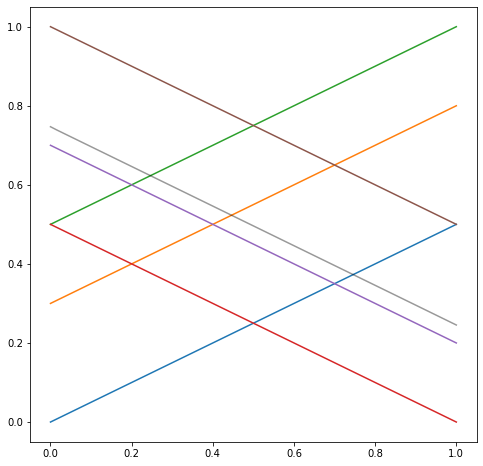

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Create a figure and axis
fig = plt.figure(figsize=(8,8))
for dem in range(d_N): #for all demonstration
    plt.plot(X[dem,:,0],Y[dem,:,0]) # plot training data
#plot preditions
#plt.plot(target_Xs,predicted_Y[:,i],marker="X",color='red',markersize=2)
line,=plt.plot(graph[0,:,0],graph[0,:,2],color='black',alpha=0.4)
plt.show()  

def update(frame):
    line.set_ydata(graph[frame,:,2])
    return line,

# Create the animation
ani = FuncAnimation(fig, update, frames=range(all_tp.shape[0]), blit=True)

# Display the animation
from IPython.display import HTML
HTML(ani.to_jshtml())
#ani.save('animation_trained_v1.mp4', fps=10, extra_args=['-vcodec', 'h264','-pix_fmt', 'yuv420p'])

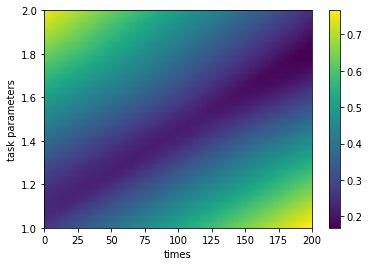

In [45]:
reshaped_data = graph[:,:,2] #taking only the predictions in 2D

# Create a heatmap plot
plt.imshow(reshaped_data,extent=[0, num_time_samples, max_tp, min_tp], cmap='viridis', aspect='auto')

# Add colorbar
plt.colorbar()

# Set labels for the axes
plt.xlabel('times')
plt.ylabel('task parameters')

# Show the plot
plt.show()

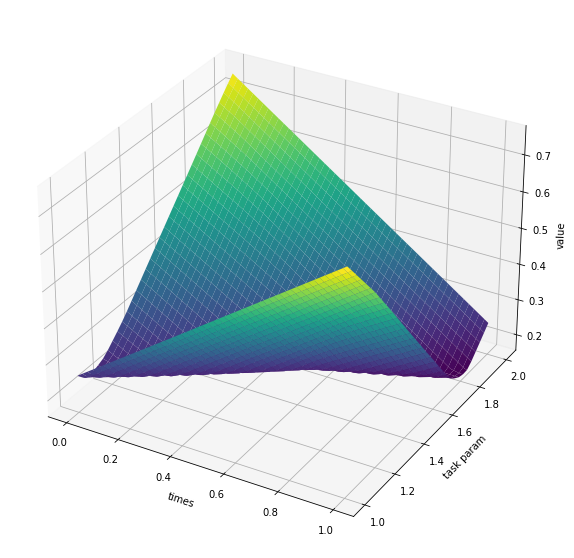

In [46]:
from mpl_toolkits import mplot3d

z = graph[:, :,2] #z values are in the 3rd dimension of graph
#print(z.shape)
z=z.T #transpose
#print(z.shape)

# Create a meshgrid from x and y values
TPs, TIMEs = np.meshgrid(tp_value_array, time_queries[:,0]) #repeats x array as many times as y and y array as many times as x

# Create a 3D axes object
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

# Create a 3D surface plot
ax.plot_surface(TIMEs, TPs, z, cmap='viridis')
#or simply
#ax.plot_surface(graph[:,:,0], graph[:,:,1], graph[:, :,2], cmap='viridis')

# Set labels for the axes
ax.set_xlabel('times')
ax.set_ylabel('task param')
ax.set_zlabel('value')

# Show the plot
plt.show()

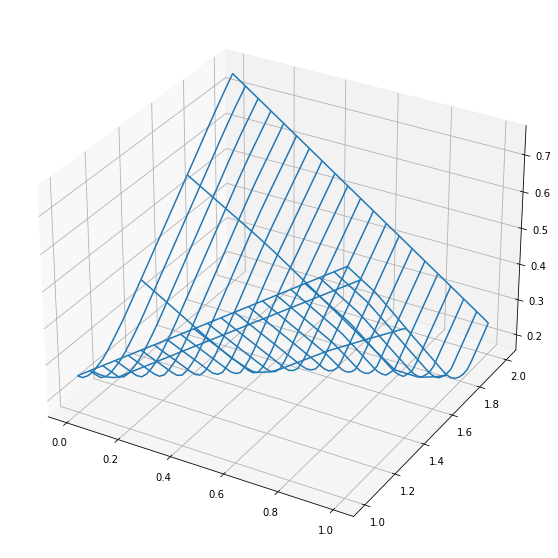

In [47]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')


# Plot a basic wireframe.
ax.plot_wireframe(graph[:,:,0], graph[:,:,1], graph[:, :,2], rstride=10, cstride=10)

plt.show()

## Mathematical transition of task parameters
Once condition, changes TP in time


In [48]:
with torch.no_grad():
        print(model( torch.from_numpy(np.array([np.concatenate(([0.5],[0.6]))])) , torch.from_numpy(time_queries1) ).numpy())

[[ 0.38011391 -4.22223851]
 [ 0.38095727 -4.22309642]
 [ 0.38234242 -4.22435146]
 [ 0.38383505 -4.22571682]
 [ 0.38553405 -4.22729404]
 [ 0.3873418  -4.22896872]
 [ 0.38991861 -4.2313327 ]
 [ 0.39249541 -4.23369667]
 [ 0.39507222 -4.23606064]
 [ 0.39764903 -4.23842461]
 [ 0.40022584 -4.24078858]
 [ 0.40280265 -4.24315256]
 [ 0.40537946 -4.24551653]
 [ 0.40795627 -4.2478805 ]
 [ 0.41053307 -4.25024447]
 [ 0.41310988 -4.25260844]
 [ 0.41568669 -4.25497242]
 [ 0.4182635  -4.25733639]
 [ 0.42084031 -4.25970036]
 [ 0.42341712 -4.26206433]
 [ 0.42599392 -4.2644283 ]
 [ 0.42857073 -4.26679228]
 [ 0.43114754 -4.26915625]
 [ 0.43372435 -4.27152022]
 [ 0.43630116 -4.27388419]
 [ 0.43887797 -4.27624816]
 [ 0.44145477 -4.27861213]
 [ 0.44403158 -4.28097611]
 [ 0.44660839 -4.28334008]
 [ 0.4491852  -4.28570405]
 [ 0.45176201 -4.28806802]
 [ 0.45433882 -4.29043199]
 [ 0.45691562 -4.29279597]
 [ 0.45949243 -4.29515994]
 [ 0.46206924 -4.29752391]
 [ 0.46464605 -4.29988788]
 [ 0.46722286 -4.30225185]
 

In [49]:
mixed_tp=graph[0].copy() #first column time
mixed_tp[:,1]=np.linspace(2,1,mixed_tp.shape[0]) #second column tp
mixed_tp[:,2]=np.linspace(0,mixed_tp.shape[0]-1,mixed_tp.shape[0]) #3d column index

for el in mixed_tp:
    with torch.no_grad():
        print("now time %f and tp %f"%(el[0], el[1]))
        pred_y= model( torch.from_numpy(np.array([np.concatenate(([0.5],[0.5]))])) , torch.from_numpy(np.array([np.concatenate(([el[0]],[el[1]]))]))  ).numpy()
        print(pred_y[0][0])
        mixed_tp[int(el[2]),2]=pred_y[0][0] #index substituted with value
print(mixed_tp)

now time 0.000000 and tp 2.000000
0.7469516137513303
now time 0.005025 and tp 1.994975
0.7414157768747569
now time 0.010050 and tp 1.989950
0.736056298004286
now time 0.015075 and tp 1.984925
0.7308173779602022
now time 0.020101 and tp 1.979899
0.7255784579161184
now time 0.025126 and tp 1.974874
0.7203395378720349
now time 0.030151 and tp 1.969849
0.7151758454245389
now time 0.035176 and tp 1.964824
0.7100312093788919
now time 0.040201 and tp 1.959799
0.704886573333245
now time 0.045226 and tp 1.954774
0.6997419372875979
now time 0.050251 and tp 1.949749
0.6945973012419511
now time 0.055276 and tp 1.944724
0.6894513336313097
now time 0.060302 and tp 1.939698
0.6843047336769721
now time 0.065327 and tp 1.934673
0.6791581337226342
now time 0.070352 and tp 1.929648
0.6740115337682966
now time 0.075377 and tp 1.924623
0.668864933813959
now time 0.080402 and tp 1.919598
0.6637183338596214
now time 0.085427 and tp 1.914573
0.6585717339052837
now time 0.090452 and tp 1.909548
0.6534251339509

0.5488066542873927
now time 0.829146 and tp 1.170854
0.5550105010915087
now time 0.834171 and tp 1.165829
0.5612143478956249
now time 0.839196 and tp 1.160804
0.5674181946997408
now time 0.844221 and tp 1.155779
0.573622041503857
now time 0.849246 and tp 1.150754
0.579825888307973
now time 0.854271 and tp 1.145729
0.586029735112089
now time 0.859296 and tp 1.140704
0.592233581916205
now time 0.864322 and tp 1.135678
0.598437428720321
now time 0.869347 and tp 1.130653
0.6046412755244371
now time 0.874372 and tp 1.125628
0.6108451223285531
now time 0.879397 and tp 1.120603
0.6170489691326692
now time 0.884422 and tp 1.115578
0.6232528159367853
now time 0.889447 and tp 1.110553
0.6294566627409014
now time 0.894472 and tp 1.105528
0.6356605095450174
now time 0.899497 and tp 1.100503
0.6418643563491335
now time 0.904523 and tp 1.095477
0.6480682031532494
now time 0.909548 and tp 1.090452
0.6542720499573655
now time 0.914573 and tp 1.085427
0.6604758967614814
now time 0.919598 and tp 1.08040

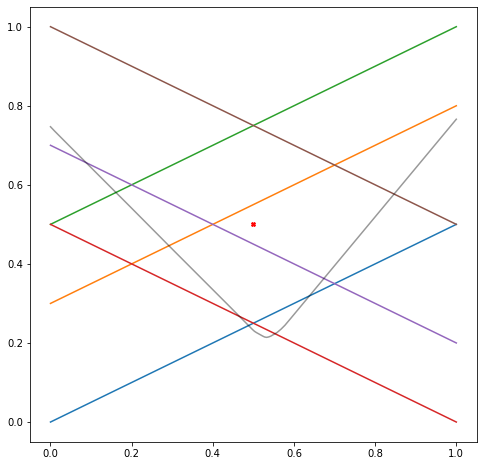

In [50]:
# Create a figure and axis
fig = plt.figure(figsize=(8,8))
for dem in range(d_N): #for all demonstration
    plt.plot(X[dem,:,0],Y[dem,:,0]) # plot training data
#plot preditions
plt.plot(0.5,0.5,marker="X",color='red',markersize=4)
line,=plt.plot(mixed_tp[:,0],mixed_tp[:,2],color='black',alpha=0.4)
plt.show()  

transition on the intersection point works perfectly, but only when there is an intersection point in the transition period
 when there is no intersection point it's gonna create a skip

In [51]:
mixed_tp=graph[0].copy() #first column time
print(mixed_tp.shape[0])
mixed_tp[:100,1]=2 #second column tp
mixed_tp[100:200,1]=1 #second column tp
#mixed_tp[150:200,1]=1.5 #second column tp
mixed_tp[:,2]=np.linspace(0,mixed_tp.shape[0]-1,mixed_tp.shape[0]) #3d column index
print(mixed_tp)
for el in mixed_tp:
    with torch.no_grad():
        print("now time %f and tp %f"%(el[0], el[1]))
        pred_y= model( torch.from_numpy(np.array([np.concatenate(([0.5],[0.5]))])) , torch.from_numpy(np.array([np.concatenate(([el[0]],[el[1]]))]))  ).numpy()
        print(pred_y[0][0])
        mixed_tp[int(el[2]),2]=pred_y[0][0] #index substituted with value
print(mixed_tp)

200
[[0.00000000e+00 2.00000000e+00 0.00000000e+00]
 [5.02512563e-03 2.00000000e+00 1.00000000e+00]
 [1.00502513e-02 2.00000000e+00 2.00000000e+00]
 [1.50753769e-02 2.00000000e+00 3.00000000e+00]
 [2.01005025e-02 2.00000000e+00 4.00000000e+00]
 [2.51256281e-02 2.00000000e+00 5.00000000e+00]
 [3.01507538e-02 2.00000000e+00 6.00000000e+00]
 [3.51758794e-02 2.00000000e+00 7.00000000e+00]
 [4.02010050e-02 2.00000000e+00 8.00000000e+00]
 [4.52261307e-02 2.00000000e+00 9.00000000e+00]
 [5.02512563e-02 2.00000000e+00 1.00000000e+01]
 [5.52763819e-02 2.00000000e+00 1.10000000e+01]
 [6.03015075e-02 2.00000000e+00 1.20000000e+01]
 [6.53266332e-02 2.00000000e+00 1.30000000e+01]
 [7.03517588e-02 2.00000000e+00 1.40000000e+01]
 [7.53768844e-02 2.00000000e+00 1.50000000e+01]
 [8.04020101e-02 2.00000000e+00 1.60000000e+01]
 [8.54271357e-02 2.00000000e+00 1.70000000e+01]
 [9.04522613e-02 2.00000000e+00 1.80000000e+01]
 [9.54773869e-02 2.00000000e+00 1.90000000e+01]
 [1.00502513e-01 2.00000000e+00 2.00

0.5148766858231921
now time 0.467337 and tp 2.000000
0.5123571126274042
now time 0.472362 and tp 2.000000
0.5098375394316164
now time 0.477387 and tp 2.000000
0.5073179662358284
now time 0.482412 and tp 2.000000
0.5047983930400405
now time 0.487437 and tp 2.000000
0.5022788198442525
now time 0.492462 and tp 2.000000
0.4997592466484646
now time 0.497487 and tp 2.000000
0.4972396734526767
now time 0.502513 and tp 1.000000
0.5131885819274995
now time 0.507538 and tp 1.000000
0.5157416396093577
now time 0.512563 and tp 1.000000
0.5182946972912158
now time 0.517588 and tp 1.000000
0.520847754973074
now time 0.522613 and tp 1.000000
0.5234008126549321
now time 0.527638 and tp 1.000000
0.5259538703367902
now time 0.532663 and tp 1.000000
0.5285069280186483
now time 0.537688 and tp 1.000000
0.5310599857005065
now time 0.542714 and tp 1.000000
0.5336130433823646
now time 0.547739 and tp 1.000000
0.5361661010642228
now time 0.552764 and tp 1.000000
0.5387191587460809
now time 0.557789 and tp 1.0

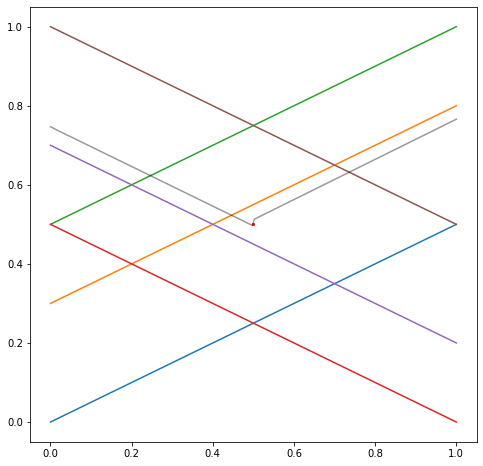

In [54]:
# Create a figure and axis
fig = plt.figure(figsize=(8,8))
for dem in range(d_N): #for all demonstration
    plt.plot(X[dem,:,0],Y[dem,:,0]) # plot training data
#plot preditions
plt.plot(0.5,0.5,marker="X",color='red',markersize=2)
line,=plt.plot(mixed_tp[:,0],mixed_tp[:,2],color='black',alpha=0.4)
plt.show()  

# Mathematical transition function

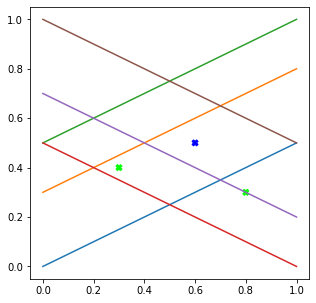

[[0.3 2.  0.4]
 [0.6 1.  0.5]
 [0.8 2.  0.3]]
(200, 4)

Finding closest couple to set interpolation points to go from 2.00 TP to 1.00 TP


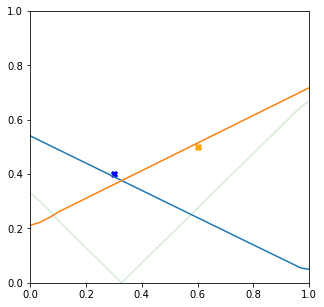

First of couple (start param) X 0.33 TP 2.00 Y 0.38 
Second of couple  (end param) X 0.33 TP 1.00 Y 0.38 

Finding closest couple to set interpolation points to go from 1.00 TP to 2.00 TP


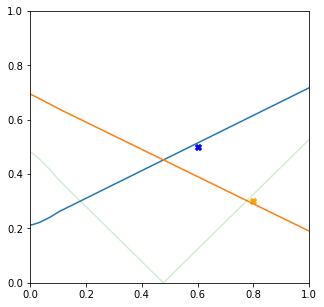

First of couple (start param) X 0.48 TP 1.00 Y 0.45 
Second of couple  (end param) X 0.48 TP 2.00 Y 0.45 
--- TIME --- X cond --- TP cond --- Y cond
[[0.         0.3        2.         0.4       ]
 [0.00502513 0.3        2.         0.4       ]
 [0.01005025 0.3        2.         0.4       ]
 [0.01507538 0.3        2.         0.4       ]
 [0.0201005  0.3        2.         0.4       ]
 [0.02512563 0.3        2.         0.4       ]
 [0.03015075 0.3        2.         0.4       ]
 [0.03517588 0.3        2.         0.4       ]
 [0.04020101 0.3        2.         0.4       ]
 [0.04522613 0.3        2.         0.4       ]
 [0.05025126 0.3        2.         0.4       ]
 [0.05527638 0.3        2.         0.4       ]
 [0.06030151 0.3        2.         0.4       ]
 [0.06532663 0.3        2.         0.4       ]
 [0.07035176 0.3        2.         0.4       ]
 [0.07537688 0.3        2.         0.4       ]
 [0.08040201 0.3        2.         0.4       ]
 [0.08542714 0.3        2.         0.4       ]
 [0.0

In [59]:
# receives the observations, with time as first dimension, and returns the matrix with the observation for every timestep
def create_observation_timestep_matrix_math_transition_tp(observations, t_min, t_max, num_time_steps, plot=True):
    #plot
    for i in range(d_y): #for every dimension in Y vector we are plotting training data and its prediction
        fig = plt.figure(figsize=(5,5))
        for j in range(d_N):
            plt.plot(X[j,:,0],Y[j,:,i]) # plot training data
        plt.scatter(observations[:,0],observations[:,-1],marker="X", c=observations[:,1], cmap='brg')
        plt.show() 
    # Use the sorted indices based on the first element (time of observation) to reorder the rows of the array (observations are ordered by time)
    sorted_indices = np.argsort(observations[:, 0])
    observations = observations[sorted_indices]
    print(observations)
    #building matrix
    observation_timestep_matrix=np.zeros((num_time_steps,1+observations.shape[1])) #create a matrix with queries of : time (in first position) associated to only one observation at a time
    times_array = np.linspace(t_min,t_max,num_time_steps)
    observation_timestep_matrix[:,0] = times_array #fill times in first position
    print(observation_timestep_matrix.shape)
    # fill for every time the right observation
    curr_obs_num=0
    interpolation_closest_points_found=False
    for time_index,curr_time in enumerate(times_array):
        next_obs_num = curr_obs_num+1
        # if current time is less than observation time OR this is last observation, fill current time with this obs
        if curr_time<=observations[curr_obs_num,0] or next_obs_num>=len(observations):
            #fill current observation in this time
            observation_timestep_matrix[time_index,1]=observations[curr_obs_num,0]
            observation_timestep_matrix[time_index,2]=observations[curr_obs_num,1]
            observation_timestep_matrix[time_index,3]=observations[curr_obs_num,2]
        else:
            #in between two observations
            # should check the WHOLE time predictions of the two observations, find the two closest points, interpolate
            if not interpolation_closest_points_found:
                print("\nFinding closest couple to set interpolation points to go from %.2f TP to %.2f TP"%(observations[curr_obs_num,1],observations[next_obs_num,1]))
                with torch.no_grad():
                    times_array_with_1st_tp = np.column_stack((times_array.reshape(num_time_steps,1), np.full((num_time_steps, 1),observations[curr_obs_num,1]))).reshape(num_time_steps,2)
                    times_array_with_2nd_tp = np.column_stack((times_array.reshape(num_time_steps,1), np.full((num_time_steps, 1),observations[next_obs_num,1]))).reshape(num_time_steps,2)
                    pred_1ob = model( torch.from_numpy(np.array([np.concatenate(([observations[curr_obs_num,0]],[observations[curr_obs_num,2]]))])) , torch.from_numpy(times_array_with_1st_tp) ).numpy()
                    pred_2ob = model( torch.from_numpy(np.array([np.concatenate(([observations[next_obs_num,0]],[observations[next_obs_num,2]]))])) , torch.from_numpy(times_array_with_2nd_tp) ).numpy()
                diff = abs(pred_1ob[:,0]-pred_2ob[:,0]) #for now only the closest couple on the y predicted
                index_min=np.argmin(diff)
                fig = plt.figure(figsize=(5,5))
                plt.plot(times_array,pred_1ob[:,0])
                plt.scatter(observations[curr_obs_num,0],observations[curr_obs_num,-1],marker="X",color='blue')
                plt.plot(times_array,pred_2ob[:,0])
                plt.scatter(observations[next_obs_num,0],observations[next_obs_num,-1],marker="X",color='orange')
                plt.plot(times_array,diff, alpha=0.2)
                plt.xlim(0, 1)
                plt.ylim(0, 1)
                plt.show()
                print("First of couple (start param) X %.2f TP %.2f Y %.2f "%(times_array[index_min], observations[curr_obs_num,1], pred_1ob[index_min,0] ))
                print("Second of couple  (end param) X %.2f TP %.2f Y %.2f "%(times_array[index_min], observations[next_obs_num,1], pred_2ob[index_min,0] ))
                start_param=[ times_array[index_min] , observations[curr_obs_num,1] , pred_1ob[index_min,0] ]
                end_param = [ times_array[index_min] , observations[next_obs_num,1] , pred_2ob[index_min,0] ]
                interpolation_closest_points_found=True
            # calculate fraction of interpolation
            fraction = (curr_time - observations[curr_obs_num,0]) / (observations[next_obs_num,0] - observations[curr_obs_num,0])
            #interpolated_param = start_param + fraction * (end_param - start_param)
            observation_timestep_matrix[time_index,1]=start_param[0]+ fraction * (end_param[0] - start_param[0])
            observation_timestep_matrix[time_index,2]=start_param[1]+ fraction * (end_param[1] - start_param[1])
            observation_timestep_matrix[time_index,3]=start_param[2]+ fraction * (end_param[2] - start_param[2])
            #if time is same or more than the second observations
            if curr_time>=observations[next_obs_num,0]:
                curr_obs_num = curr_obs_num+1
                next_obs_num = curr_obs_num+1
                interpolation_closest_points_found=False

    return observation_timestep_matrix
        
    
observations=np.array([np.concatenate(([0.3],[2.0],[0.4])), np.concatenate(([0.6],[1.0],[0.5])), np.concatenate(([0.8],[2.0],[0.3])),])
observation_timestep_matrix=create_observation_timestep_matrix_math_transition_tp( observations=observations , t_min=0, t_max=1, num_time_steps=200 )
#print("FULL MATRIX")
print("--- TIME --- X cond --- TP cond --- Y cond")
print(observation_timestep_matrix)

Matrix shape
(200, 4)
X of the observations in time:


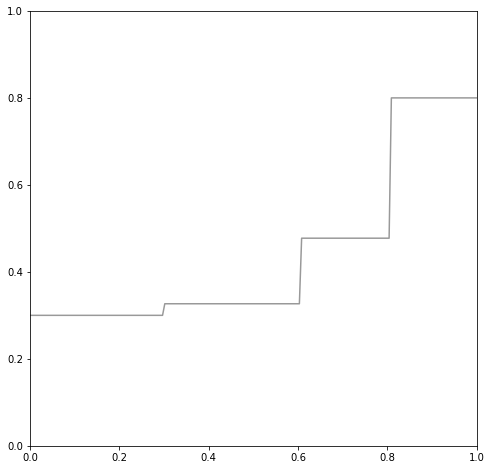

TP of the observations in time:


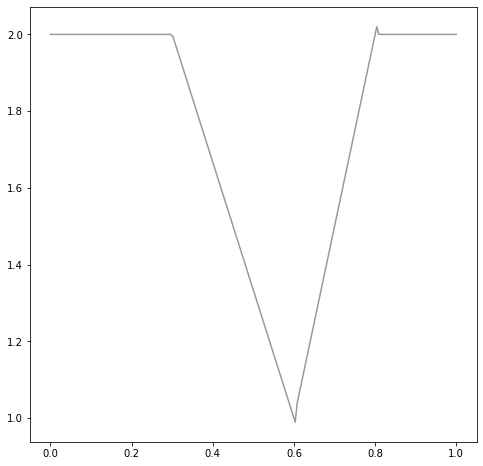

Y of the observations in time:


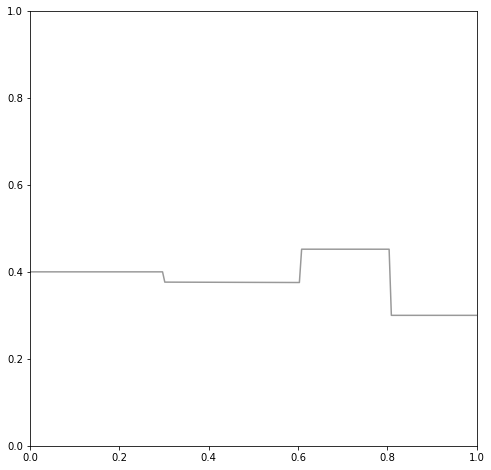

FULL graph observations in time
(blue initial time, pink final time)


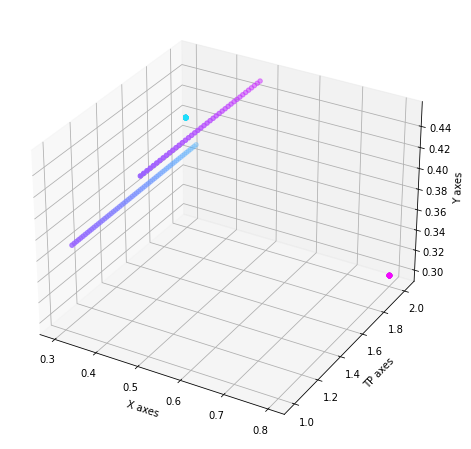

In [60]:
# plot change of condition point in time
def plot_observation_timestep_matrix(observation_timestep_matrix):
    print("Matrix shape")
    print(observation_timestep_matrix.shape)
    print("X of the observations in time:")
    fig = plt.figure(figsize=(8,8))
    line,=plt.plot(observation_timestep_matrix[:,0],observation_timestep_matrix[:,1],color='black',alpha=0.4)
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.show()  
    print("TP of the observations in time:")
    fig = plt.figure(figsize=(8,8))
    line,=plt.plot(observation_timestep_matrix[:,0],observation_timestep_matrix[:,2],color='black',alpha=0.4)
    plt.show()  
    print("Y of the observations in time:")
    fig = plt.figure(figsize=(8,8))
    line,=plt.plot(observation_timestep_matrix[:,0],observation_timestep_matrix[:,3],color='black',alpha=0.4)
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.show()  
    print("FULL graph observations in time")
    print("(blue initial time, pink final time)")
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(observation_timestep_matrix[:,1],observation_timestep_matrix[:,2],observation_timestep_matrix[:,3], c=observation_timestep_matrix[:,0], cmap='cool', marker='o')
    ax.set_xlabel('X axes')
    ax.set_ylabel('TP axes')
    ax.set_zlabel('Y axes')
    plt.show()

plot_observation_timestep_matrix(observation_timestep_matrix)

(200, 1)
(6, 200, 2) (6, 200, 1)
(6, 200, 2) (6, 200, 1)
(6, 200, 2) (6, 200, 1)
(6, 200, 2) (6, 200, 1)
(6, 200, 2) (6, 200, 1)
(6, 200, 2) (6, 200, 1)


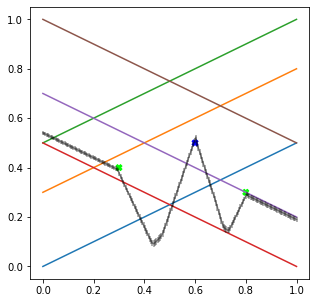

In [63]:
def predict_model_observation_for_timestep(array_observation_for_time, target_X, plot=True):
    #instead of passing the array of multiple observations, pass the computed array with a single observation of every time step
    predicted_Y = np.zeros((len(target_X),d_y))
    print(predicted_Y.shape)
    predicted_std = np.zeros((len(target_X),d_y))
    for time_index, time in enumerate(target_X):
        with torch.no_grad():
            prediction = model( torch.from_numpy(np.array([ array_observation_for_time[time_index] ])) , torch.from_numpy(np.array([time])) ).numpy()
            #print(time_index, time, array_observation_for_time[time_index])
            #print(prediction)
            predicted_Y[time_index] = prediction[:,:d_y]
            predicted_std[time_index] = np.log(1+np.exp(prediction[:,d_y:]))
    if plot: # We highly recommend that you customize your own plot function, but you can use this function as default
        for i in range(d_y): #for every feature in Y vector we are plotting training data and its prediction
            fig = plt.figure(figsize=(5,5))
            for j in range(d_N):
                print(X.shape, Y.shape)
                plt.plot(X[j,:,0],Y[j,:,i]) # plot training data assuming X[j,:,0] is time
            #plt.plot(X[j,:,0],predicted_Y[:,i],marker="o",color='red')
            plt.errorbar(X[j,:,0],predicted_Y[:,i],yerr=predicted_std[:,i],color='black',alpha=0.4)
            plt.scatter(observations[:,0],observations[:,d_x+i],marker="X", c=observations[:,1], cmap='brg')
            plt.show()  
    return predicted_Y, predicted_std
target_X_with_TP = np.column_stack((observation_timestep_matrix[:,0], observation_timestep_matrix[:,2]))
predicted_Y, predicted_std = predict_model_observation_for_timestep(np.delete(observation_timestep_matrix[:, 1:], 1, axis=1),target_X_with_TP) #passing the observations without the first column that is time and WITHOUT TP, passing time array aside  with TP

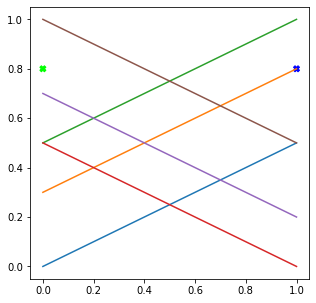

[[0.  2.  0.8]
 [1.  1.  0.8]]
(200, 4)

Finding closest couple to set interpolation points to go from 2.00 TP to 1.00 TP


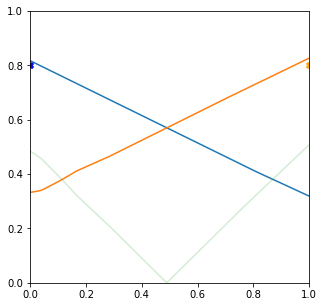

First of couple (start param) X 0.49 TP 2.00 Y 0.57 
Second of couple  (end param) X 0.49 TP 1.00 Y 0.57 
(200, 1)
(6, 200, 2) (6, 200, 1)
(6, 200, 2) (6, 200, 1)
(6, 200, 2) (6, 200, 1)
(6, 200, 2) (6, 200, 1)
(6, 200, 2) (6, 200, 1)
(6, 200, 2) (6, 200, 1)


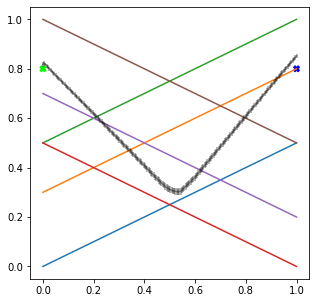

In [64]:
# Another compact test
observations=np.array([ np.concatenate(([0.0],[2.0],[0.8])), np.concatenate(([1.0],[1.0],[0.8])),  ])
observation_timestep_matrix=create_observation_timestep_matrix_math_transition_tp( observations=observations , t_min=0, t_max=1, num_time_steps=200 )
target_X_with_TP = np.column_stack((observation_timestep_matrix[:,0], observation_timestep_matrix[:,2]))
predicted_Y, predicted_std=predict_model_observation_for_timestep(np.delete(observation_timestep_matrix[:, 1:], 1, axis=1),target_X_with_TP) #passing the observations without the first column that is time and WITHOUT TP, passing time array aside with TP